# Logistic Regression

In [1]:
#importing the required libraries
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import pandas as pd
import sqlite3
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from scipy.linalg import eigh
import re
from gensim.models import word2vec
import pickle
from gensim.models import KeyedVectors
import string
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from sklearn import decomposition
pca = decomposition.PCA()
from sklearn.manifold import TSNE
from scipy.sparse import csc_matrix
from scipy.sparse import csr_matrix
from scipy.sparse import lil_matrix
from tqdm import tqdm
import string
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import label_binarize
from prettytable import PrettyTable
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.decomposition import TruncatedSVD
from sklearn.utils import resample
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import copy

/home/blurryface/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
#loading the data through sqlite and preprocesing it a little bit.
temp = sqlite3.connect('database.sqlite')
temp = pd.read_sql_query("""SELECT * FROM Reviews WHERE SCORE != 3""", temp)
def partiton(x):
    if x > 3:
        return 'positive'
    else:
        return 'negative'
score = temp['Score']
positive_negative = score.map(partiton)
temp['Score'] = positive_negative

In [6]:
#sorting the data in ascending order according to the time stamp
temp.sort_values('Time', inplace=True)
temp.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...
417859,451878,B00004CXX9,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
212472,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."


In [7]:
#getting rid of the duplicates
final = temp.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [8]:
#Removing all the points where Denominator < Numerator
final = final[final.HelpfulnessNumerator <= final.HelpfulnessDenominator]
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...
417859,451878,B00004CXX9,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...


In [9]:
final.shape

(364171, 10)

In [11]:
final = final.iloc[: 60000, :]

In [12]:
final.shape

(60000, 10)

# Text Preprocessing: Stemming, stop-word removal and Lemmatization.

#### Doing the text processing for text as well as summary of the review

In [11]:
stop = set(stopwords.words('english'))
sno = nltk.stem.SnowballStemmer('english')
def clean_html(sentence):
    clean = re.compile('<.*?>')
    cleantext = re.sub(clean, ' ', sentence)
    return cleantext
def clean_punctuation(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return cleaned

In [14]:
i=0
strl = ' '
final_string = []
all_positive_words = []
all_negative_words = []
s = ''
for sent in tqdm(final['Text'].values):
    sent = clean_html(sent)
    filtered_sentence = []
    for w in sent.split():
        for cleaned_words in clean_punctuation(w).split():
            if ((cleaned_words.isalpha()) & (len(cleaned_words) > 2)):
                if (cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) 
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) 
                else:
                    continue
            else:
                continue 
    str1 = b" ".join(filtered_sentence) 
    
    final_string.append(str1)
    i+=1

100%|██████████| 60000/60000 [00:55<00:00, 1089.90it/s]


In [15]:
final['CleanedText']=final_string 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [16]:
final.head(3)
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...
417859,451878,B00004CXX9,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...


In [17]:
i=0
strl = ' '
final_string = []
all_positive_words = []
all_negative_words = []
s = ''
for sent in tqdm(final['Summary'].values):
    sent = clean_html(sent)
    filtered_sentence = []
    for w in sent.split():
        for cleaned_words in clean_punctuation(w).split():
            if ((cleaned_words.isalpha()) & (len(cleaned_words) > 2)):
                if (cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) 
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) 
                else:
                    continue
            else:
                continue 
    str1 = b" ".join(filtered_sentence) 
    
    final_string.append(str1)
    i+=1

100%|██████████| 60000/60000 [00:05<00:00, 11322.90it/s]


In [18]:
final['CleanedSummary']=final_string 
final['CleanedSummary']=final['CleanedSummary'].str.decode("utf-8")

In [19]:
final.head(3)
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedSummary
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...,everi book educ
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...,whole seri great way spend time child
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...,entertainingl funni
417859,451878,B00004CXX9,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...,modern day fairi tale
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...,fantast


In [20]:
#Saving the cleaned data for future assignments
clean_data = open("clean_data_1.pickle", "wb")
pickle.dump(final, clean_data)
clean_data.close()

In [2]:
pickle_in = open("clean_data_1.pickle", "rb")
final = pickle.load(pickle_in)

In [3]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText,CleanedSummary
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...,everi book educ
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,rememb see show air televis year ago child sis...,whole seri great way spend time child
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,beetlejuic well written movi everyth excel act...,entertainingl funni
417859,451878,B00004CXX9,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",twist rumplestiskin captur film star michael k...,modern day fairi tale
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...,fantast


In [4]:
final.shape

(60000, 12)

In [5]:
scores = final['Score'].get_values()
li = lambda x: 1 if x=='positive'  else 0
final_scores = []
for i in range(0,60000):
    final_scores.append(li(scores[i]))
final_scores = np.asarray(final_scores)
final_scores.shape

(60000,)

In [6]:
print(final['Score'].value_counts())

positive    53147
negative     6853
Name: Score, dtype: int64


# Dividing the whole data into train, CV and test sets

In [7]:
#train data
X_train = final[0: 40000]
Y_train = final_scores[0: 40000]
print(X_train.shape)
print(Y_train.shape)

(40000, 12)
(40000,)


In [8]:
X_CV = final[40000: 50000]
Y_CV = final_scores[40000: 50000]
print(X_CV.shape)
print(Y_CV.shape)

(10000, 12)
(10000,)


In [9]:
#test data
X_test = final[50000: ]
Y_test = final_scores[50000: ]
print(X_test.shape)
print(Y_test.shape)

(10000, 12)
(10000,)


# BOW

In [10]:
count_vect = CountVectorizer(max_features=2000)
X_train_bow = count_vect.fit_transform(X_train['CleanedText'].values)
X_train_bow.shape

(40000, 2000)

In [11]:
train_bow = open("train_bow.pickle", "wb")
pickle.dump(X_train_bow, train_bow)
train_bow.close()

In [12]:
X_CV_bow = count_vect.transform(X_CV['CleanedText'].values)
X_CV_bow.shape

(10000, 2000)

In [13]:
X_test_bow = count_vect.transform(X_test['CleanedText'].values)
X_test_bow.shape

(10000, 2000)

In [14]:
test_bow = open("test_bow.pickle", "wb")
pickle.dump(X_test_bow, test_bow)
test_bow.close()

# Logistic Regression on BOW Vectorizer.

In [15]:
def scores(x, y):
    C= [10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10, 10**2, 10**4]
    scores = []
    for c in tqdm(C):
        LR = LogisticRegression(penalty='l2', C=c, fit_intercept=False, class_weight={1: 1, 0: 5.3})
        LR.fit(X_train_bow, Y_train)
        pred = LR.predict(x)
        auc = roc_auc_score(y, pred)
        scores.append(auc)
    return scores

In [16]:
cv_scores = scores(X_CV_bow, Y_CV)

100%|██████████| 10/10 [00:15<00:00,  1.55s/it]


In [17]:
train_scores = scores(X_train_bow, Y_train)

100%|██████████| 10/10 [00:15<00:00,  1.51s/it]


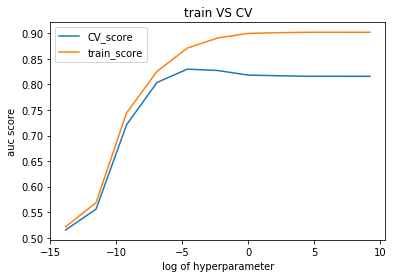

In [18]:
C= [10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10, 10**2, 10**4]
log_C = np.log(np.asarray(C))
plt.plot(log_C, cv_scores, label='CV_score')
plt.plot(log_C, train_scores, label='train_score')
plt.title('train VS CV')
plt.ylabel('auc score')
plt.xlabel('log of hyperparameter')
plt.legend()
plt.show()

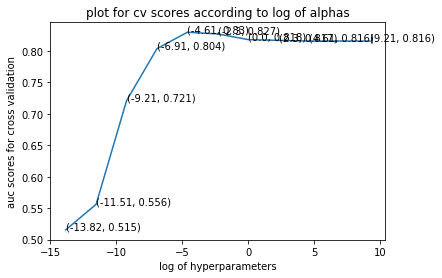

The auc score for each hyperparameter value for cross validation is :  [0.515 0.556 0.721 0.804 0.83  0.827 0.818 0.817 0.816 0.816]


In [19]:
plt.plot(log_C, cv_scores )

plt.title('plot for cv scores according to log of alphas')
for xy in zip(np.round(log_C, 2), np.round(cv_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('log of hyperparameters')
plt.ylabel('auc scores for cross validation')
plt.show()

print("The auc score for each hyperparameter value for cross validation is : ", np.round(cv_scores,3))

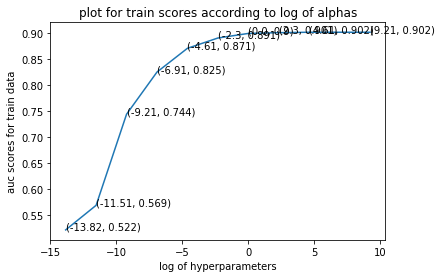

The auc score for each hyperparameter value for train data is :  [0.522 0.569 0.744 0.825 0.871 0.891 0.9   0.901 0.902 0.902]


In [20]:
plt.plot(log_C, train_scores )

plt.title('plot for train scores according to log of alphas')
for xy in zip(np.round(log_C, 2), np.round(train_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('log of hyperparameters')
plt.ylabel('auc scores for train data')
plt.show()

print("The auc score for each hyperparameter value for train data is : ", np.round(train_scores,3))

In [21]:
C= [10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10, 10**2, 10**4]
optimal_hyperparameter_for_cv = C[cv_scores.index(max(cv_scores))]
print('\nThe optimal value of hyperparameter for cv is {} and it\'s value is {}'.format(optimal_hyperparameter_for_cv, max(cv_scores)))


The optimal value of hyperparameter for cv is 0.01 and it's value is 0.8299307652669926


In [22]:
C= [10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10, 10**2, 10**4]
optimal_hyperparameter_for_train = C[train_scores.index(max(train_scores))]
print('\nThe optimal value of hyperparameter for train is {} and it\'s value is {}'.format(optimal_hyperparameter_for_train, max(train_scores)))


The optimal value of hyperparameter for train is 100 and it's value is 0.9021059261294924


In [23]:
x = PrettyTable()
x.field_names = ['hyperparameters for cv', 'cv score', 'hyperparameters for train', 'train score']
for z, y in zip(sorted(cv_scores, reverse=True), sorted(train_scores, reverse=True)):
    x.add_row([C[cv_scores.index(z)], z, C[train_scores.index(y)], y])
print(x)

+------------------------+--------------------+---------------------------+--------------------+
| hyperparameters for cv |      cv score      | hyperparameters for train |    train score     |
+------------------------+--------------------+---------------------------+--------------------+
|          0.01          | 0.8299307652669926 |            100            | 0.9021059261294924 |
|          0.1           | 0.8272419650560828 |           10000           | 0.9020918784234829 |
|           1            | 0.8181899206691593 |             10            | 0.9012685177341945 |
|           10           | 0.816981832997795  |             1             | 0.8998303635105791 |
|          100           | 0.8159317778736458 |            0.1            | 0.8909916310416907 |
|         10000          | 0.8158748561978717 |            0.01           | 0.8711809803483144 |
|         0.001          | 0.8038561439459304 |           0.001           | 0.8254504154515815 |
|         0.0001         | 0.7

## From the above the graphs and the table the optimal value of the hyperparameter 'C' is choosen to be 1

In [24]:
LR_optimal = LogisticRegression(penalty='l2', C=1, fit_intercept=False, class_weight={1: 1, 0: 5.3})

# fitting the model
LR_optimal.fit(X_train_bow, Y_train)

# predict the response
pred = LR_optimal.predict(X_test_bow)

# evaluate auc_score
auc_score = roc_auc_score(Y_test, pred)

In [25]:
print('\nThe auc score for test data for C = {} is {:2f}'.format(1, auc_score))


The auc score for test data for C = 1 is 0.814890


## Pertubation Test

In [15]:
X_train_bow.shape

(40000, 2000)

In [23]:
x_trainp=lil_matrix(X_train_bow).toarray()
e=np.random.normal(0,0.01)
x_trainp = np.add(x_trainp.data, e, casting='unsafe')

In [24]:
np.count_nonzero(x_trainp)

80000000

In [25]:
x_trainp.shape

(40000, 2000)

In [29]:
LR_optimal_noise = LogisticRegression(penalty='l2', C=0.1, fit_intercept=False, class_weight={1: 1, 0: 5.3})

# fitting the model
LR_optimal_noise.fit(x_trainp, Y_train)


LogisticRegression(C=0.1, class_weight={1: 1, 0: 5.3}, dual=False,
          fit_intercept=False, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [30]:
w_without_noise = LR_optimal.coef_

In [31]:
w_with_noise = LR_optimal_noise.coef_

In [32]:
w_without_noise = np.add(w_without_noise, 10**-6)

In [33]:
w_with_noise = np.add(w_with_noise, 10**-6)

In [34]:
w = np.multiply(np.abs(np.divide
                (np.subtract(w_without_noise, w_with_noise), w_without_noise)), 100)

In [35]:
w

array([[28.42076384, 26.13357752, 72.52723865, ..., 40.22431998,
        31.44011572, 39.31735936]])

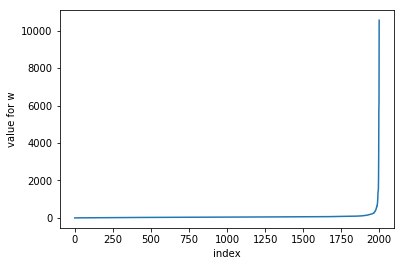

In [36]:
a = []
w_sorted = np.sort(w)
w_sorted = w_sorted.reshape(2000,)
for i in range(2000):
    a.append(i)
plt.plot(a, w_sorted)
plt.xlabel('index')
plt.ylabel('value for w')
plt.show()

In [37]:
n = np.linspace(10, 100, 10)
x = PrettyTable()
x.field_names = ['percentile value', 'w value']
for i in n:
    x.add_row([i, np.percentile(w, i)])
print(x)

+------------------+--------------------+
| percentile value |      w value       |
+------------------+--------------------+
|       10.0       | 14.970671415107148 |
|       20.0       | 23.967141554547595 |
|       30.0       |  30.5648212033653  |
|       40.0       | 37.17609534324542  |
|       50.0       | 43.66686728676162  |
|       60.0       | 50.02485204463025  |
|       70.0       | 56.71356858609134  |
|       80.0       | 64.33458722892375  |
|       90.0       | 80.01838470910602  |
|      100.0       | 10554.518462997388 |
+------------------+--------------------+


### As from the above the above table it can be seen that there is sudden rise in the value of the w from 90th percentile from 100th percentile.

In [38]:
x = PrettyTable()
x.field_names = ['percentile value', 'w value']
for i in range(90, 101):
    x.add_row([i, np.percentile(w, i)])
print(x)

+------------------+--------------------+
| percentile value |      w value       |
+------------------+--------------------+
|        90        | 80.01838470910602  |
|        91        | 84.96261508955898  |
|        92        | 90.71171127296772  |
|        93        | 99.75179915283805  |
|        94        | 106.46681460683546 |
|        95        | 118.28525318772601 |
|        96        | 145.96930679962887 |
|        97        | 190.14090149484372 |
|        98        | 246.14746364068105 |
|        99        | 497.7204755097119  |
|       100        | 10554.518462997388 |
+------------------+--------------------+


### Again from the above the above table it can be seen that there is sudden rise in the value of the w from 99th percentile from 100th percentile.

In [39]:
a = np.linspace(99, 100, 11)
x = PrettyTable()
x.field_names = ['percentile value', 'w value']
for i in a:
    x.add_row([i, np.percentile(w, i)])
print(x)

+------------------+--------------------+
| percentile value |      w value       |
+------------------+--------------------+
|       99.0       | 497.7204755097119  |
|       99.1       | 540.4448770893927  |
|       99.2       | 589.0750239937881  |
|       99.3       |  663.202008642188  |
|       99.4       | 721.8458225169541  |
|       99.5       | 882.7212485536896  |
|       99.6       | 1307.1291112229842 |
|       99.7       | 1427.4976185081575 |
|       99.8       | 2127.0185189948825 |
|       99.9       | 5777.3743115885845 |
|      100.0       | 10554.518462997388 |
+------------------+--------------------+


## According to the above table a major change occur after 99.1 percentile of w

In [40]:
a = np.percentile(w, 99.1)

In [41]:
b = w[w>a]

In [42]:
b

array([10554.518463  ,  2124.37542682,  6150.98158792,   721.47697502,
         663.77987586,  5777.00033033,   564.79682148,  1383.75445976,
        3445.92151548,   663.19793506,   882.03642915,  1427.09147421,
         782.95155756,  1306.8213789 ,  1019.00031041,   590.72675492,
         589.06170358,  1562.47290743])

In [43]:
b.shape

(18,)

In [44]:
def show_features(vectorizer, array):
    print('the below table shows the features which may be multicollinear')
    print()
    x = PrettyTable()
    x.field_names = ["value for features",
                     'features']
    coefs_with_fns = sorted(zip(array, vectorizer.get_feature_names()))
    for (coef_1, fn_1) in coefs_with_fns:
        x.add_row([coef_1, fn_1])
    print(x)

In [45]:
show_features(count_vect, b)

the below table shows the features which may be multicollinear

+--------------------+----------+
| value for features | features |
+--------------------+----------+
| 564.7968214802942  |  acquir  |
| 589.0617035830571  |  adjust  |
| 590.7267549244293  | address  |
| 663.1979350565864  |  activ   |
| 663.7798758568225  |  accord  |
| 721.4769750217164  |  accept  |
| 782.9515575581256  |   add    |
| 882.0364291473895  |  actual  |
| 1019.0003104106622 |  addit   |
| 1306.821378899555  |  addict  |
| 1383.7544597587298 |  across  |
| 1427.0914742084929 |    ad    |
| 1562.4729074333065 |  admit   |
| 2124.3754268176212 | absolut  |
| 3445.9215154793774 |   act    |
| 5777.000330330924  |   acid   |
|  6150.98158791575  |  absorb  |
| 10554.518462997388 |   abl    |
+--------------------+----------+


## Top 20 features based on positive and negative reviews

In [46]:
def getImpFeatures(vectorizer,w_vec,top_n_features):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(w_vec[0], feature_names))
    print("These are the top 20 important Features Which are most widely used in Positive and Negative Reviews:")
    pos_features = coefs_with_fns[len(feature_names)-top_n_features:len(feature_names)];
    neg_features = coefs_with_fns[0:top_n_features];
    print("\n")
    print("Positive: \t\t\t\t Negative:")
    print("\n")
    for i in range(20):
        print(pos_features[i],"\t\t",neg_features[i])

In [47]:
getImpFeatures(count_vect, w_without_noise, 20)

These are the top 20 important Features Which are most widely used in Positive and Negative Reviews:


Positive: 				 Negative:


(1.9942039925478665, 'refresh') 		 (-4.147038297859576, 'worst')
(2.001228960234208, 'firm') 		 (-2.731375711795108, 'unpleas')
(2.0133949491649723, 'versatil') 		 (-2.6574401781010906, 'horribl')
(2.0577517966392764, 'eight') 		 (-2.635695974720982, 'wors')
(2.117248154106327, 'lemongrass') 		 (-2.615329967318194, 'bland')
(2.1309714804352127, 'addict') 		 (-2.4475322854185455, 'terribl')
(2.2729634266871077, 'winner') 		 (-2.3091662950120884, 'aw')
(2.287965745719044, 'relax') 		 (-2.244199987464707, 'sorri')
(2.3017453933355143, 'stress') 		 (-2.239764163670711, 'tasteless')
(2.3072821723165524, 'grandmoth') 		 (-2.2153570152504924, 'threw')
(2.3143381854221783, 'bonus') 		 (-2.2014593899132047, 'fed')
(2.3800206028881945, 'hearti') 		 (-2.1229680049862236, 'disappoint')
(2.3886949688596677, 'desert') 		 (-2.07672481558565, 'unfortun')
(2.391071095197794,

## Confusion Matrix and result of the classifier

In [48]:
conf_matrix = confusion_matrix(Y_test, pred)
conf_matrix

array([[ 893,  337],
       [ 844, 7926]])

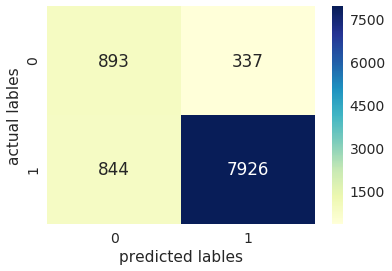

In [49]:
df_cm = pd.DataFrame(conf_matrix, range(2),
                  range(2))
#plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True, fmt="d",cmap="YlGnBu")
plt.xlabel('predicted lables')
plt.ylabel('actual lables')
plt.show()

In [50]:
print(classification_report(Y_test, pred))

             precision    recall  f1-score   support

          0       0.51      0.73      0.60      1230
          1       0.96      0.90      0.93      8770

avg / total       0.90      0.88      0.89     10000



# TF-IDF

In [27]:
tf_idf_vect = TfidfVectorizer(max_features=2000)
X_train_tfidf = tf_idf_vect.fit_transform(X_train['CleanedText'].values)
X_train_tfidf.shape

(40000, 2000)

In [28]:
X_CV_tfidf = tf_idf_vect.transform(X_CV['CleanedText'].values)
X_CV_tfidf.shape

(10000, 2000)

In [29]:
X_test_tfidf = tf_idf_vect.transform(X_test['CleanedText'].values)
X_test_tfidf.shape

(10000, 2000)

# Logistic Regression on TF-IDF vectorizer.

In [30]:
def scores(x, y):
    C= [10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10, 10**2, 10**4]
    scores = []
    for c in tqdm(C):
        LR = LogisticRegression(penalty='l2', C=c, fit_intercept=False, class_weight={1: 1, 0: 5.3})
        LR.fit(X_train_tfidf, Y_train)
        pred = LR.predict(x)
        auc = roc_auc_score(y, pred)
        scores.append(auc)
    return scores

In [31]:
cv_scores = scores(X_CV_tfidf, Y_CV)

100%|██████████| 10/10 [00:05<00:00,  1.89it/s]


In [32]:
train_scores = scores(X_train_tfidf, Y_train)

100%|██████████| 10/10 [00:05<00:00,  1.68it/s]


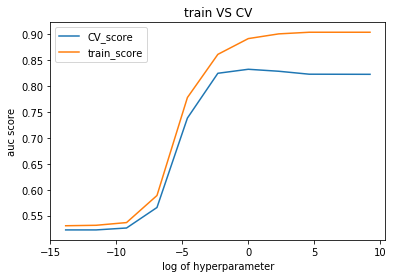

In [33]:
C= [10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10, 10**2, 10**4]
log_C = np.log(np.asarray(C))
plt.plot(log_C, cv_scores, label='CV_score')
plt.plot(log_C, train_scores, label='train_score')
plt.title('train VS CV')
plt.ylabel('auc score')
plt.xlabel('log of hyperparameter')
plt.legend()
plt.show()

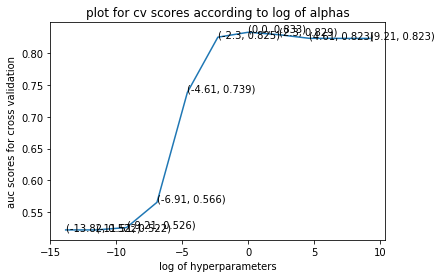

The auc score for each hyperparameter value for cross validation is :  [0.522 0.522 0.526 0.566 0.739 0.825 0.833 0.829 0.823 0.823]


In [34]:
plt.plot(log_C, cv_scores )

plt.title('plot for cv scores according to log of alphas')
for xy in zip(np.round(log_C, 2), np.round(cv_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('log of hyperparameters')
plt.ylabel('auc scores for cross validation')
plt.show()

print("The auc score for each hyperparameter value for cross validation is : ", np.round(cv_scores,3))

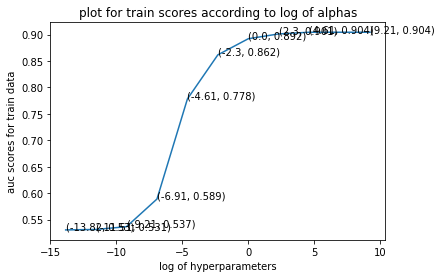

The auc score for each hyperparameter value for train data is :  [0.53  0.531 0.537 0.589 0.778 0.862 0.892 0.901 0.904 0.904]


In [35]:
plt.plot(log_C, train_scores )

plt.title('plot for train scores according to log of alphas')
for xy in zip(np.round(log_C, 2), np.round(train_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('log of hyperparameters')
plt.ylabel('auc scores for train data')
plt.show()

print("The auc score for each hyperparameter value for train data is : ", np.round(train_scores,3))

In [37]:
C= [10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10, 10**2, 10**4]
optimal_hyperparameter_for_cv = C[cv_scores.index(max(cv_scores))]
print('\nThe optimal value of hyperparameter for cv is {} and it\'s value is {}'.format(optimal_hyperparameter_for_cv, max(cv_scores)))


The optimal value of hyperparameter for cv is 1 and it's value is 0.8328023140159141


In [38]:
C= [10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10, 10**2, 10**4]
optimal_hyperparameter_for_train = C[train_scores.index(max(train_scores))]
print('\nThe optimal value of hyperparameter for train is {} and it\'s value is {}'.format(optimal_hyperparameter_for_train, max(train_scores)))


The optimal value of hyperparameter for train is 10000 and it's value is 0.9043468651535168


In [39]:
x = PrettyTable()
x.field_names = ['hyperparameters for cv', 'cv score', 'hyperparameters for train', 'train score']
for z, y in zip(sorted(cv_scores, reverse=True), sorted(train_scores, reverse=True)):
    x.add_row([C[cv_scores.index(z)], z, C[train_scores.index(y)], y])
print(x)

+------------------------+--------------------+---------------------------+--------------------+
| hyperparameters for cv |      cv score      | hyperparameters for train |    train score     |
+------------------------+--------------------+---------------------------+--------------------+
|           1            | 0.8328023140159141 |           10000           | 0.9043468651535168 |
|           10           | 0.8289758292589398 |            100            | 0.9043457909359254 |
|          0.1           | 0.8250587192023775 |             10            | 0.9011885283685024 |
|          100           | 0.8232829127121083 |             1             | 0.8920753699622914 |
|         10000          | 0.8230552260090117 |            0.1            | 0.8615958196576987 |
|          0.01          | 0.7385355251174384 |            0.01           | 0.7781926223360591 |
|         0.001          | 0.5657392927331991 |           0.001           | 0.5888995702881002 |
|         0.0001         | 0.5

## From the above the graphs and the table the optimal value of the hyperparameter 'C' is choosen to be 1

In [42]:
LR_optimal = LogisticRegression(penalty='l2', C=1, fit_intercept=False, class_weight={1: 1, 0: 5.3})

# fitting the model
LR_optimal.fit(X_train_tfidf, Y_train)

# predict the response
pred = LR_optimal.predict(X_test_tfidf)

# evaluate auc_score
auc_score = roc_auc_score(Y_test, pred)

In [43]:
print('\nThe auc score for test data for C = {} is {:2f}'.format(1, auc_score))


The auc score for test data for C = 1 is 0.828879


## Confusion Matrix and result of the classifier

In [44]:
conf_matrix = confusion_matrix(Y_test, pred)
conf_matrix

array([[ 919,  311],
       [ 784, 7986]])

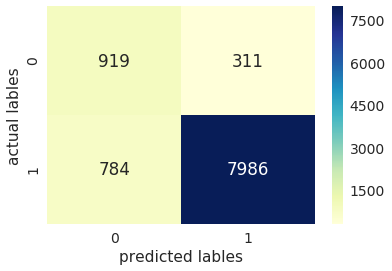

In [45]:
df_cm = pd.DataFrame(conf_matrix, range(2),
                  range(2))
#plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True, fmt="d",cmap="YlGnBu")
plt.xlabel('predicted lables')
plt.ylabel('actual lables')
plt.show()

In [46]:
print(classification_report(Y_test, pred))

             precision    recall  f1-score   support

          0       0.54      0.75      0.63      1230
          1       0.96      0.91      0.94      8770

avg / total       0.91      0.89      0.90     10000



## Top 20 features based on positive and negative reviews

In [47]:
def getImpFeatures(vectorizer,w_vec,top_n_features):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(w_vec[0], feature_names))
    print("These are the top 20 important Features Which are most widely used in Positive and Negative Reviews:")
    pos_features = coefs_with_fns[len(feature_names)-top_n_features:len(feature_names)];
    neg_features = coefs_with_fns[0:top_n_features];
    print("\n")
    print("Positive: \t\t\t\t Negative:")
    print("\n")
    for i in range(20):
        print(pos_features[i],"\t\t",neg_features[i])

In [48]:
getImpFeatures(tf_idf_vect, LR_optimal.coef_, 20)

These are the top 20 important Features Which are most widely used in Positive and Negative Reviews:


Positive: 				 Negative:


(3.826039972000464, 'uniqu') 		 (-8.349179570378729, 'worst')
(3.8728081888965336, 'beat') 		 (-7.867975191035626, 'disappoint')
(3.9448873931501325, 'tasti') 		 (-6.63715994669848, 'bland')
(4.029877375720433, 'hook') 		 (-6.392540392879503, 'horribl')
(4.110655935669937, 'keep') 		 (-6.216217418315475, 'terribl')
(4.190476967659066, 'fast') 		 (-5.619284370806179, 'aw')
(4.307373338376369, 'good') 		 (-5.58736688293995, 'unfortun')
(4.476740856218895, 'awesom') 		 (-5.4955336364190845, 'wors')
(4.941514908076657, 'yummi') 		 (-4.988092277284411, 'return')
(5.051165664833014, 'favorit') 		 (-4.7886113894230595, 'sorri')
(5.46558690163992, 'nice') 		 (-4.631614611891668, 'threw')
(5.46562631280613, 'amaz') 		 (-4.605262599854487, 'gross')
(5.5979362022510974, 'wonder') 		 (-4.427093378117601, 'weak')
(5.8017262770459554, 'addict') 		 (-4.303681534867766, 're

## Checking Performance with different lambdas/C with L1

C =  1e-06 , No.of non zero vals:  0
Score:  12.3
Error:  87.7
C =  1e-05 , No.of non zero vals:  0
Score:  12.3
Error:  87.7
C =  0.0001 , No.of non zero vals:  0
Score:  87.7
Error:  12.3
C =  0.001 , No.of non zero vals:  0
Score:  87.7
Error:  12.3
C =  0.01 , No.of non zero vals:  1
Score:  87.7
Error:  12.3
C =  0.1 , No.of non zero vals:  109
Score:  89.32
Error:  10.68
C =  1 , No.of non zero vals:  847
Score:  91.85
Error:  8.150000000000002
C =  10 , No.of non zero vals:  1830
Score:  91.75
Error:  8.250000000000002
C =  100 , No.of non zero vals:  1979
Score:  91.47999999999999
Error:  8.520000000000005
C =  10000 , No.of non zero vals:  2000
Score:  91.47
Error:  8.530000000000005


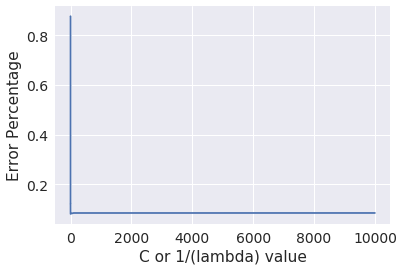

In [51]:
C= [10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10, 10**2, 10**4]
li_of_errors=[]
for i in C:
    model = LogisticRegression(C=i, penalty='l1')
    model.fit(X_train_tfidf,Y_train)
    w = model.coef_
    err_val = 1-model.score(X_test_tfidf,Y_test);
    print("C = ",i,", No.of non zero vals: ",np.count_nonzero(w))
    print("Score: ",(1-err_val)*100)
    print("Error: ",(err_val)*100)
    li_of_errors.append(err_val)

plt.plot(C,li_of_errors)
plt.xlabel('C or 1/(lambda) value')
plt.ylabel('Error Percentage')
plt.show()

## Observation:- As the value of C increases the number of non-zero value also increases

# W2V

In [54]:
i=0
list_of_sent =[]
for sent in X_train['Text'].values:
    filtered_sentence =[]
    sent = clean_html(sent)
    for w in sent.split():
        for cleaned_words in clean_punctuation(w).split():
            if(cleaned_words.isalpha()):
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue
    list_of_sent.append(filtered_sentence)

In [55]:
w2v_model=Word2Vec(list_of_sent, min_count=5 ,size=50)

In [56]:
w2v_words = list(w2v_model.wv.vocab)

# Average W2V

In [57]:
X_train_avgw2v = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_train_avgw2v.append(sent_vec)
print(len(X_train_avgw2v))
print(len(X_train_avgw2v[0]))

100%|██████████| 40000/40000 [01:59<00:00, 335.78it/s]

40000
50


In [58]:
X_train_avgw2v = np.asarray(X_train_avgw2v)

In [59]:
X_train_avgw2v = StandardScaler().fit_transform(X_train_avgw2v)

In [60]:
train_w2v = open("train_w2v.pickle", "wb")
pickle.dump(X_train_avgw2v, train_w2v)
train_w2v.close()

In [61]:
i=0
list_of_sentence =[]
for sent in X_CV['Text'].values:
    filtered_sentence =[]
    sent = clean_html(sent)
    for w in sent.split():
        for cleaned_words in clean_punctuation(w).split():
            if(cleaned_words.isalpha()):
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue
    list_of_sentence.append(filtered_sentence)

In [62]:
X_CV_avgw2v = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentence): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_CV_avgw2v.append(sent_vec)
print(len(X_CV_avgw2v))
print(len(X_CV_avgw2v[0]))

100%|██████████| 10000/10000 [00:27<00:00, 367.38it/s]

10000
50


In [63]:
X_CV_avgw2v = np.asarray(X_CV_avgw2v)
X_CV_avgw2v = StandardScaler().fit_transform(X_CV_avgw2v)
X_CV_avgw2v.shape

(10000, 50)

In [64]:
CV_w2v = open("CV_w2v.pickle", "wb")
pickle.dump(X_CV_avgw2v, CV_w2v)
CV_w2v.close()

In [65]:
i=0
list_of_sen =[]
for sent in X_test['Text'].values:
    filtered_sentence =[]
    sent = clean_html(sent)
    for w in sent.split():
        for cleaned_words in clean_punctuation(w).split():
            if(cleaned_words.isalpha()):
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue
    list_of_sen.append(filtered_sentence)

In [66]:
X_test_avgw2v = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sen): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_test_avgw2v.append(sent_vec)
print(len(X_test_avgw2v))
print(len(X_test_avgw2v[0]))

100%|██████████| 10000/10000 [00:24<00:00, 407.25it/s]

10000
50


In [67]:
X_test_avgw2v = np.asarray(X_test_avgw2v)
X_test_avgw2v = StandardScaler().fit_transform(X_test_avgw2v)
X_test_avgw2v.shape

(10000, 50)

In [68]:
test_w2v = open("test_w2v.pickle", "wb")
pickle.dump(X_test_avgw2v, test_w2v)
test_w2v.close()

# Logistic Regression on Average W2V

In [69]:
def scores(x, y):
    C= [10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10, 10**2, 10**4]
    scores = []
    for c in tqdm(C):
        LR = LogisticRegression(penalty='l2', C=c, fit_intercept=False, class_weight={1: 1, 0: 5.3})
        LR.fit(X_train_avgw2v, Y_train)
        pred = LR.predict(x)
        auc = roc_auc_score(y, pred)
        scores.append(auc)
    return scores

In [76]:
cv_scores = scores(X_CV_avgw2v, Y_CV)

100%|██████████| 10/10 [00:04<00:00,  2.46it/s]


In [77]:
train_scores = scores(X_train_avgw2v, Y_train)

100%|██████████| 10/10 [00:04<00:00,  2.41it/s]


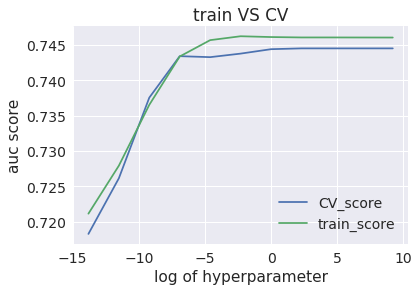

In [78]:
C= [10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10, 10**2, 10**4]
log_C = np.log(np.asarray(C))
plt.plot(log_C, cv_scores, label='CV_score')
plt.plot(log_C, train_scores, label='train_score')
plt.title('train VS CV')
plt.ylabel('auc score')
plt.xlabel('log of hyperparameter')
plt.legend()
plt.show()

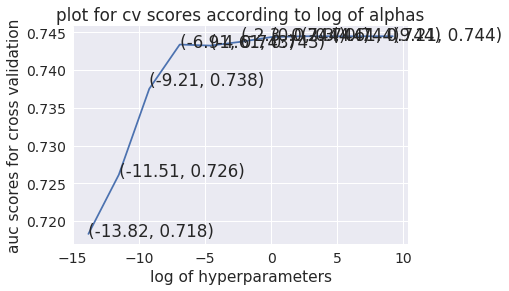

The auc score for each hyperparameter value for cross validation is :  [0.718 0.726 0.738 0.743 0.743 0.744 0.744 0.744 0.744 0.744]


In [79]:
plt.plot(log_C, cv_scores )

plt.title('plot for cv scores according to log of alphas')
for xy in zip(np.round(log_C, 2), np.round(cv_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('log of hyperparameters')
plt.ylabel('auc scores for cross validation')
plt.show()

print("The auc score for each hyperparameter value for cross validation is : ", np.round(cv_scores,3))

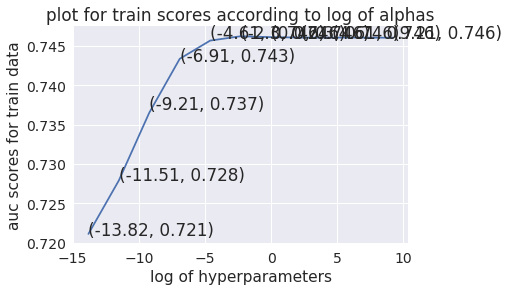

The auc score for each hyperparameter value for train data is :  [0.721 0.728 0.737 0.743 0.746 0.746 0.746 0.746 0.746 0.746]


In [80]:
plt.plot(log_C, train_scores )

plt.title('plot for train scores according to log of alphas')
for xy in zip(np.round(log_C, 2), np.round(train_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('log of hyperparameters')
plt.ylabel('auc scores for train data')
plt.show()

print("The auc score for each hyperparameter value for train data is : ", np.round(train_scores,3))

In [81]:
C= [10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10, 10**2, 10**4]
optimal_hyperparameter_for_cv = C[cv_scores.index(max(cv_scores))]
print('\nThe optimal value of hyperparameter for cv is {} and it\'s value is {}'.format(optimal_hyperparameter_for_cv, max(cv_scores)))


The optimal value of hyperparameter for cv is 10 and it's value is 0.7444988196241972


In [82]:
C= [10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10, 10**2, 10**4]
optimal_hyperparameter_for_train = C[train_scores.index(max(train_scores))]
print('\nThe optimal value of hyperparameter for train is {} and it\'s value is {}'.format(optimal_hyperparameter_for_train, max(train_scores)))


The optimal value of hyperparameter for train is 0.1 and it's value is 0.7462143950499646


In [83]:
x = PrettyTable()
x.field_names = ['hyperparameters for cv', 'cv score', 'hyperparameters for train', 'train score']
for z, y in zip(sorted(cv_scores, reverse=True), sorted(train_scores, reverse=True)):
    x.add_row([C[cv_scores.index(z)], z, C[train_scores.index(y)], y])
print(x)

+------------------------+--------------------+---------------------------+--------------------+
| hyperparameters for cv |      cv score      | hyperparameters for train |    train score     |
+------------------------+--------------------+---------------------------+--------------------+
|           10           | 0.7444988196241972 |            0.1            | 0.7462143950499646 |
|           10           | 0.7444988196241972 |             1             | 0.7461009391842964 |
|           10           | 0.7444988196241972 |             10            | 0.7460447483602578 |
|           1            | 0.7443849762726489 |             10            | 0.7460447483602578 |
|          0.1           | 0.7437588378391334 |           10000           | 0.7460307006542483 |
|         0.001          | 0.7433985835490365 |            0.01           | 0.7456633118628156 |
|          0.01          | 0.7432592752372736 |           0.001           | 0.7433530427716915 |
|         0.0001         | 0.7

## From the above the graphs and the table the optimal value of the hyperparameter 'C' is choosen to be 10

In [84]:
LR_optimal = LogisticRegression(penalty='l2', C=10, fit_intercept=False, class_weight={1: 1, 0: 5.3})

# fitting the model
LR_optimal.fit(X_train_avgw2v, Y_train)

# predict the response
pred = LR_optimal.predict(X_test_avgw2v)

# evaluate auc_score
auc_score = roc_auc_score(Y_test, pred)

In [86]:
print('\nThe auc score for test data for C = {} is {:2f}'.format(10, auc_score))


The auc score for test data for C = 10 is 0.741806


## Confusion Matrix and the result of the clasifier

In [87]:
conf_matrix = confusion_matrix(Y_test, pred)
conf_matrix

array([[1163,   67],
       [4051, 4719]])

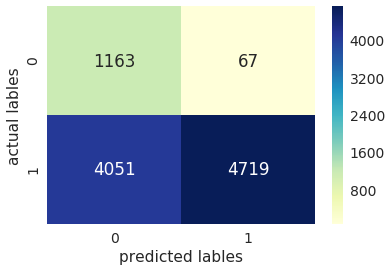

In [88]:
df_cm = pd.DataFrame(conf_matrix, range(2),
                  range(2))
#plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True, fmt="d",cmap="YlGnBu")
plt.xlabel('predicted lables')
plt.ylabel('actual lables')
plt.show()

In [89]:
print(classification_report(Y_test, pred))

             precision    recall  f1-score   support

          0       0.22      0.95      0.36      1230
          1       0.99      0.54      0.70      8770

avg / total       0.89      0.59      0.65     10000



# TF-IDF W2V

In [12]:
i=0
list_of_sent =[]
for sent in X_train['CleanedText'].values:
    filtered_sentence =[]
    sent = clean_html(sent)
    for w in sent.split():
        for cleaned_words in clean_punctuation(w).split():
            if(cleaned_words.isalpha()):
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue
    list_of_sent.append(filtered_sentence)


In [13]:
w2v_model=Word2Vec(list_of_sent, min_count=5 ,size=50)

In [14]:
w2v_words = list(w2v_model.wv.vocab)

In [15]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train['CleanedText'].values)
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [16]:
tfidf_feat = model.get_feature_names()

X_train_tf = []
row=0;
for sent in tqdm(list_of_sent):  
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_train_tf.append(sent_vec)
    row += 1

100%|██████████| 40000/40000 [00:55<00:00, 714.37it/s]


In [17]:
X_train_tfidfw2v = np.asarray(X_train_tf)
X_train_tfidfw2v = StandardScaler().fit_transform(X_train_tfidfw2v)
X_train_tfidfw2v.shape

(40000, 50)

In [18]:
train_tfidfw2v = open("train_tfidfw2v.pickle", "wb")
pickle.dump(X_train_tfidfw2v, train_tfidfw2v)
train_tfidfw2v.close()

In [19]:
i=0
list_of_sentence =[]
for sent in X_CV['CleanedText'].values:
    filtered_sentence =[]
    sent = clean_html(sent)
    for w in sent.split():
        for cleaned_words in clean_punctuation(w).split():
            if(cleaned_words.isalpha()):
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue
    list_of_sentence.append(filtered_sentence)

In [20]:
X_CV_tfidf = model.transform(X_CV['CleanedText'].values)

In [21]:
tfidf_feat = model.get_feature_names()

X_CV_tf = []
row=0;
for sent in tqdm(list_of_sentence):  
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_CV_tf.append(sent_vec)
    row += 1

100%|██████████| 10000/10000 [00:18<00:00, 542.50it/s]


In [22]:
X_CV_tfidfw2v = np.asarray(X_CV_tf)
X_CV_tfidfw2v = StandardScaler().fit_transform(X_CV_tfidfw2v)
X_CV_tfidfw2v.shape

(10000, 50)

In [23]:
CV_tfidfw2v = open("CV_tfidfw2v.pickle", "wb")
pickle.dump(X_CV_tfidfw2v, CV_tfidfw2v)
CV_tfidfw2v.close()

In [24]:
i=0
list_of_sen =[]
for sent in X_test['CleanedText'].values:
    filtered_sentence =[]
    sent = clean_html(sent)
    for w in sent.split():
        for cleaned_words in clean_punctuation(w).split():
            if(cleaned_words.isalpha()):
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue
    list_of_sen.append(filtered_sentence)


In [25]:
X_test_tfidf = model.transform(X_test['CleanedText'].values)


In [26]:
tfidf_feat = model.get_feature_names()

X_test_tf = []
row=0;
for sent in tqdm(list_of_sen):  
    sent_vec = np.zeros(50) 
    weight_sum =0; 
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_test_tf.append(sent_vec)
    row += 1

100%|██████████| 10000/10000 [00:17<00:00, 587.36it/s]


In [27]:
X_test_tfidfw2v = np.asarray(X_test_tf)
X_test_tfidfw2v = StandardScaler().fit_transform(X_test_tfidfw2v)
X_test_tfidfw2v.shape

(10000, 50)

In [28]:
test_tfidfw2v = open("test_tfidfw2v.pickle", "wb")
pickle.dump(X_test_tfidfw2v, test_tfidfw2v)
test_tfidfw2v.close()

## Logistic Regression on TF-IDF weighted W2V

In [29]:
def scores(x, y):
    C= [10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10, 10**2, 10**4]
    scores = []
    for c in tqdm(C):
        LR = LogisticRegression(penalty='l2', C=c, fit_intercept=False, class_weight={1: 1, 0: 5.3})
        LR.fit(X_train_tfidfw2v, Y_train)
        pred = LR.predict(x)
        auc = roc_auc_score(y, pred)
        scores.append(auc)
    return scores

In [30]:
cv_scores = scores(X_CV_tfidfw2v, Y_CV)

100%|██████████| 10/10 [00:04<00:00,  2.31it/s]


In [31]:
train_scores = scores(X_train_tfidfw2v, Y_train)

100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


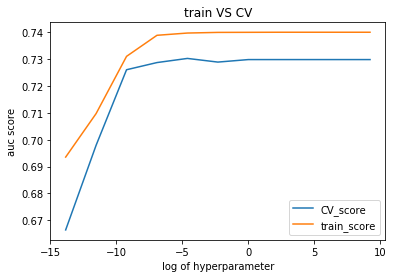

In [32]:
C= [10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10, 10**2, 10**4]
log_C = np.log(np.asarray(C))
plt.plot(log_C, cv_scores, label='CV_score')
plt.plot(log_C, train_scores, label='train_score')
plt.title('train VS CV')
plt.ylabel('auc score')
plt.xlabel('log of hyperparameter')
plt.legend()
plt.show()

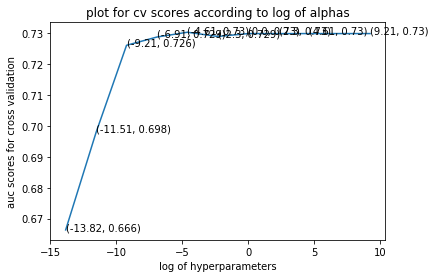

The auc score for each hyperparameter value for cross validation is :  [0.666 0.698 0.726 0.729 0.73  0.729 0.73  0.73  0.73  0.73 ]


In [33]:
plt.plot(log_C, cv_scores )

plt.title('plot for cv scores according to log of alphas')
for xy in zip(np.round(log_C, 2), np.round(cv_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('log of hyperparameters')
plt.ylabel('auc scores for cross validation')
plt.show()

print("The auc score for each hyperparameter value for cross validation is : ", np.round(cv_scores,3))

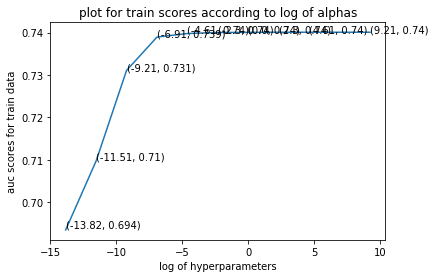

The auc score for each hyperparameter value for train data is :  [0.694 0.71  0.731 0.739 0.74  0.74  0.74  0.74  0.74  0.74 ]


In [34]:
plt.plot(log_C, train_scores )

plt.title('plot for train scores according to log of alphas')
for xy in zip(np.round(log_C, 2), np.round(train_scores,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
plt.xlabel('log of hyperparameters')
plt.ylabel('auc scores for train data')
plt.show()

print("The auc score for each hyperparameter value for train data is : ", np.round(train_scores,3))

In [35]:
C= [10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10, 10**2, 10**4]
optimal_hyperparameter_for_cv = C[cv_scores.index(max(cv_scores))]
print('\nThe optimal value of hyperparameter for cv is {} and it\'s value is {}'.format(optimal_hyperparameter_for_cv, max(cv_scores)))


The optimal value of hyperparameter for cv is 0.01 and it's value is 0.7303095939986579


In [36]:
C= [10**-6, 10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10, 10**2, 10**4]
optimal_hyperparameter_for_train = C[train_scores.index(max(train_scores))]
print('\nThe optimal value of hyperparameter for train is {} and it\'s value is {}'.format(optimal_hyperparameter_for_train, max(train_scores)))


The optimal value of hyperparameter for train is 10 and it's value is 0.7400738963525124


In [37]:
x = PrettyTable()
x.field_names = ['hyperparameters for cv', 'cv score', 'hyperparameters for train', 'train score']
for z, y in zip(sorted(cv_scores, reverse=True), sorted(train_scores, reverse=True)):
    x.add_row([C[cv_scores.index(z)], z, C[train_scores.index(y)], y])
print(x)

+------------------------+--------------------+---------------------------+--------------------+
| hyperparameters for cv |      cv score      | hyperparameters for train |    train score     |
+------------------------+--------------------+---------------------------+--------------------+
|          0.01          | 0.7303095939986579 |             10            | 0.7400738963525124 |
|           1            | 0.7298796855526795 |             10            | 0.7400738963525124 |
|           1            | 0.7298796855526795 |             10            | 0.7400738963525124 |
|           1            | 0.7298796855526795 |             1             | 0.7400458009404931 |
|           1            | 0.7298796855526795 |            0.1            | 0.7400166313108826 |
|          0.1           | 0.7289434737800786 |            0.01           | 0.7397756718735363 |
|         0.001          | 0.7287659680279935 |           0.001           | 0.7389339666078729 |
|         0.0001         | 0.7

## From the above the graphs and the table the optimal value of the hyperparameter 'C' is choosen to be 1

In [38]:
LR_optimal = LogisticRegression(penalty='l2', C=1, fit_intercept=False, class_weight={1: 1, 0: 5.3})

# fitting the model
LR_optimal.fit(X_train_tfidfw2v, Y_train)

# predict the response
pred = LR_optimal.predict(X_test_tfidfw2v)

# evaluate auc_score
auc_score = roc_auc_score(Y_test, pred)

In [39]:
print('\nThe auc score for test data for C = {} is {:2f}'.format(1, auc_score))


The auc score for test data for C = 1 is 0.733704


## Confusion Matrix and the result of the clasifier

In [40]:
conf_matrix = confusion_matrix(Y_test, pred)
conf_matrix

array([[1139,   91],
       [4022, 4748]])

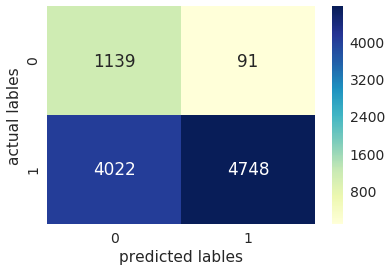

In [41]:
df_cm = pd.DataFrame(conf_matrix, range(2),
                  range(2))
#plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True, fmt="d",cmap="YlGnBu")
plt.xlabel('predicted lables')
plt.ylabel('actual lables')
plt.show()

In [42]:
print(classification_report(Y_test, pred))

             precision    recall  f1-score   support

          0       0.22      0.93      0.36      1230
          1       0.98      0.54      0.70      8770

avg / total       0.89      0.59      0.66     10000



In [44]:
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Hyperparameter", "f1-Score on the test data"]
x.add_row(['BOW', 'Logistic Regression', 1, '0.8148'])
x.add_row(['TF-IDF', 'Logistic Regression', 1, '0.8288'])
x.add_row(['Average W2V', 'Logistic Regression',10, '0.7418'])
x.add_row(['TF-IDF Weighted W2V', 'Logistic Regression', 1, '0.7337'])
print(x)

+---------------------+---------------------+----------------+---------------------------+
|      Vectorizer     |        Model        | Hyperparameter | f1-Score on the test data |
+---------------------+---------------------+----------------+---------------------------+
|         BOW         | Logistic Regression |       1        |           0.8148          |
|        TF-IDF       | Logistic Regression |       1        |           0.8288          |
|     Average W2V     | Logistic Regression |       10       |           0.7418          |
| TF-IDF Weighted W2V | Logistic Regression |       1        |           0.7337          |
+---------------------+---------------------+----------------+---------------------------+


### Observation :- Amongst all the models the model with TF-IDF vectorizer performed best with slight improvment as compared to the model with BOW vectorizer.